# **Understanding LGD scoring models**

This is my workbook associated with the reading of this LinkedIn [pulse](https://www.linkedin.com/pulse/understanding-lgd-risk-denis-burakov) by [Denis Burakov](https://linktr.ee/deburky).

- Data can be found [here](https://github.com/shawn-y-sun/Credit_Risk_Model_LoanDefaults/blob/main/loan_data_defaults.csv): <https://github.com/shawn-y-sun/Credit_Risk_Model_LoanDefaults>;
- Github repo for code reference: <https://github.com/deburky/lgd-scoring-models>.

## 1 Methodologies

Loss Given Default (LGD) risk management model is widely used in order to quantify the percentage of the exposure at default (EAD) will be subject to economic loss for the lender. Applications in:
- Risk-Weighted Assets (RWA) calculation, 
- Expected credit loss estimation, 
- Pricing, and 
- Distressed assets management strategies.

The LGD parameter can be categorized into two types: 

- **Market LGD**: calculated based on market data; and 
- **Workout LGD**: bank's internal recovery history (primary focus of Risk Modeler).

Financial institutions employ two primary approaches: 
- **LGD Long-Run** models for performing loans (customers who are not in default PIT but defaulted within 12 months after the reference date, risk drivers are normally collected 12 months prior to default date); and 
- **LGD In-Default** models for non-performing loans (customers who have defaulted), the vintage approach is often employed in LGD In-Default models, where data is collected at each month after the default date, and a time variable is introduced as an additional risk driver.

Others considerations:
- LR-CR approach: loss vs cure components;
- the model might be splitted into secured and unsecured parts.

Typically LDG distribution are **U-shaped**, depend on the varying recovery rates observed across different lending products, collateral quality, and the effectiveness of collection and recovery strategiesbut. Obviously poor data quality can also cause additional outliers in the LGD distribution.

The following methods were employed to model LGD risk:
- [Linear regression](#24-linear-regression)
- [Weight-of-Evidence Logistic Regression (WOE LR)](#25-logistic-regression-on-woe)
- [Constrained LightGBM](#26-boosting) (Tree-based methods are particularly favored by banks because they offer interpretability, and the leaf values can be directly interpreted as LGD grades).

## 2 Modeling

Required: `pandas`, `numpy`, `matplotlib`, `scikit-learn`, `scipy`, `lightgbm`

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'

### 2.1 Dataset

Loading dataset

In [2]:
loan_data = pd.read_csv('loan_data_defaults.csv', index_col=0, low_memory=False)
loan_data = loan_data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
loan_data[['int_rate', 'recoveries', 'collection_recovery_fee', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'funded_amnt']].head(10)

,int_rate,recoveries,collection_recovery_fee,total_rec_prncp,total_rec_int,total_rec_late_fee,funded_amnt
1,15.27,117.08,1.1100,456.46,435.17,0.0,2500
8,21.28,189.06,2.0900,162.02,294.94,0.0,5600
9,12.69,269.29,2.5200,673.48,533.42,0.0,5375
12,13.49,444.30,4.1600,1256.14,570.26,0.0,9000
14,10.65,645.10,6.3145,5433.47,1393.42,0.0,10000
21,12.42,0.00,0.0000,10694.96,3330.44,0.0,21000
24,11.71,269.31,2.5700,1305.58,475.25,0.0,6000
26,14.27,0.00,0.0000,0.00,0.00,0.0,15000
27,16.77,260.96,2.3000,629.05,719.11,0.0,5000
46,8.90,107.00,1.0700,4217.38,696.99,0.0,5000


Data dictionary (for variables that concerned in this topic)

- `int_rate`: Interest Rate on the loan
- `MRP`: Maximum recovery period (we assumed 36 months)
- `recoveries`: Post charge off gross recovery
- `collection_recovery_fee`: Post charge off collection fee, collected from the obligor
- `total_rec_prncp`: Principal received to date
- `total_rec_int`: Interest received to date
- `total_rec_late_fee`: Late fees received to date
- `funded_amnt`: The total amount committed to that loan at that point in time.


### 2.2 Some pre-processings

Discounting the recovery cash-flows, we use data post-default event to calculate the LGD

In [3]:
# interest rate
loan_data['int_rate'] /= 100

# maximum recovery period - assuming 3 years
MRP = 36

# discount factor
loan_data['discount_factor'] = (1 + loan_data['int_rate'] / 12) ** MRP

# recovery cash-flows
loan_data['recovery_cf'] = (loan_data['recoveries'] # gross recovery
                            + loan_data['collection_recovery_fee'] # collected from the obligor on colateral assets
                            + loan_data['total_rec_prncp'] # recovery principle
                            + loan_data['total_rec_int'] # recovery interest of loan
                            + loan_data['total_rec_late_fee'] # recovery late fee of the loan
                            )

# discounting recovery cash-flows, assuming cash is collected at the end of periods (?)
loan_data['recoveries_cf_disc'] = loan_data['recovery_cf'] / loan_data['discount_factor']

# realized LGD calculation
loan_data['LGD'] = (loan_data['funded_amnt'] - loan_data['recoveries_cf_disc']) / loan_data['funded_amnt']

# flooring & capping, null handling
loan_data['LGD'] = np.where(
    loan_data['LGD'] < 0, 0,
    (np.where((loan_data['LGD'] > 1) | (loan_data['LGD'].isnull()), 1,
              loan_data['LGD'])
        )
)

Processing on **utilization**

In [4]:
# current account utilization
loan_data['utilization'] = (    loan_data['revol_bal'].astype(float) / # Total credit revolving balance
                                loan_data['total_rev_hi_lim'].astype(float) # Total revolving high credit/credit limit
                            )
# capping
loan_data['utilization'] = np.where(
    loan_data['utilization'] > 1, 1,
    loan_data['utilization']
)

### 2.3 Train/Test split

Features

In [5]:
# features and outcome that our models concern
lgd_cols = ['funded_amnt', # The total amount committed to that loan at that point in time.
            'total_pymnt', # Payments received to date for total amount funded
            'last_pymnt_amnt', # Last total payment amount received
            'zip_code', # The first 3 numbers of the zip code provided by the borrower in the loan application.
            'grade', # LC assigned loan grade
            'utilization', # processed above
            'annual_inc', # The self-reported annual income provided by the borrower during registration.
            'purpose', # A category provided by the borrower for the loan request. 
            'inq_last_6mths', # The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
            'mths_since_last_delinq', # The number of months since the borrower's last delinquency.
            'dti', # A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, 
            # excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
            'LGD' # processed above, our ground true
            ]

loan_data_lgd = loan_data[lgd_cols].copy() # for safety

loan_data_lgd.rename({
    'total_pymnt': 'payments_received',
    'funded_amnt': 'ead', # this dataset is somehow for bullet payment loans
    # so when the default event happens, all fund are exposure at default
    'LGD': 'lgd',
}, axis=1, inplace=True)

Now we have this list of features for testing

In [6]:
features_testing = [
    'ead',
    'payments_received',
    'last_pymnt_amnt',
    'zip_code', 
    'grade',
    'utilization',
    'annual_inc',
    'purpose',
    'inq_last_6mths',
    'mths_since_last_delinq',
    'dti']

In [7]:
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
random_state = 24 # for re-productibility

In [8]:
# features and target
X = loan_data_lgd[features_testing + ['lgd']].copy()
y = X.pop('lgd') # pop() removes `lgd` from X and return what we've deleted, ie assign it to y simultaneously

# sampling (train / test)
ix_train, ix_test = train_test_split(
    X.index,
    test_size=0.3,
    random_state=random_state
)

print(f"Train: {len(ix_train):,.0f}\nTest: {len(ix_test):,.0f}")


Train: 30,265
Test: 12,971


In [9]:
y.head(10)

1     0.743782
8     0.938534
9     0.811619
12    0.830982
14    0.455926
21    0.538991
24    0.758816
26    1.000000
27    0.804450
46    0.230132
Name: lgd, dtype: float64

### 2.4 Linear regression

In [10]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [11]:
features_lr = [feature for feature in features_testing if feature != 'ead']

# specify categorical features
feats_cat = X[features_lr].select_dtypes(include=[object]).columns

# one-hot encoding for categorical features
transformer = ColumnTransformer( # Applies transformers to columns of an array or pandas DataFrame
    transformers=[
        ('OneHotEncoder',
         OneHotEncoder( # Encode categorical features as a one-hot numeric array
             drop='first', # drop the first category in each feature
             handle_unknown='ignore'), # result one-hot encoding column to be all zeros for unknown cat
            feats_cat
         )
    ],
    remainder='passthrough', # retain not specified columns but present in data to be passed to fit (ie., the numerical features)
    verbose_feature_names_out=False # not prefix any feature name
)

# imputation for missing values
imputer = SimpleImputer( # Univariate imputer for completing missing values with simple strategies.
            missing_values=np.nan, # definition of missing values, and to be imputed
            strategy='median' # replace missing values using the median along each column
            )

# calling the model
lin_reg = LinearRegression()

# defining the pipeline, what will be processed from data to output
sk_lr_model = Pipeline(
    steps=[
        ("transformer", transformer),
        ("imputer", imputer),
        ("regressor", lin_reg)
    ]
)

# training the model
sk_lr_model.fit(X.loc[ix_train][features_lr], y.loc[ix_train])

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OneHotEncoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['zip_code', 'grade', 'purpose'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('imputer', SimpleImputer(strategy='median')),
                ('regressor', LinearRegression())])

Predict on original data

In [12]:
X['lgd_pred_lr'] = sk_lr_model.predict(X)

Rank correlation

In [13]:
spearmanr(y.loc[ix_test],
          X.loc[ix_test]['lgd_pred_lr'])[0]

0.6966000996027512

### 2.5 Logistic regression on WOE

In [ ]:
import uuid
from optbinning import BinningProcess #, OptimalBinning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

Dataset duplication utility

In [25]:
def duplicate_dataset(df, id_col):
    lgd_woe = []
    for i in df[id_col].unique():
        mask = (df[id_col] == i)
        df_bad = df[mask].loc[df[mask].index.repeat(df[mask].bads)]
        df_bad['is_default'] = 1
        df_good = df[mask].loc[df[mask].index.repeat(df[mask].goods)]
        df_good['is_default'] = 0
        
        df_all = pd.concat([df_good, df_bad], axis=0) # append 2 sets of bad & good, get 100 rows of data
        lgd_woe.append(df_all)
        
    lgd_woe = pd.concat(lgd_woe)
    return (lgd_woe)

Creating unique identifier and prepare goods/bads columns. We will treat each loan ID as a bin, then we duplicate that row of data to gain mutiple rows and corresponding bads/goods rate

In [16]:
loan_data_lgd['id'] = [uuid.uuid4() for _ in range(len(loan_data_lgd.index))]
loan_data_lgd['bads'] = (loan_data_lgd['lgd'] * 100).round().astype(int)
loan_data_lgd['goods'] = 100 - loan_data_lgd['bads']

Creating duplicated dataset, because the total bads + goods are 100, the dataset was scaled 100 times.

In [17]:
start_time = time.time()

loan_data_lgd_woe = duplicate_dataset(loan_data_lgd, "id")

execution_time = time.time() - start_time
print(f"Training time: {execution_time:.4f} seconds")
print(f"Original sample size: {len(loan_data_lgd):,.0f}")
print(f"Duplicated sample size: {len(loan_data_lgd_woe):,.0f}")

Training time: 331.5879 seconds
Original sample size: 43,236
Duplicated sample size: 4,323,600


In [23]:
loan_data_lgd.to_clipboard(excel=True)

Features WOE

In [18]:
features_woe = ['payments_received',
                'zip_code',
                'grade',
                'utilization',
                'annual_inc',
                'purpose',
                'dti']

Mirroring statsmodels logistic regression

In [19]:
lr_params = {
          "fit_intercept": True,
          "penalty": "l2",
          "random_state": 72,
          "solver": "liblinear",
          }

Features with economic meaning, for WOE binning

Note: the solver here is set to [constraint programming](https://gnpalencia.org/optbinning/tutorials/tutorial_binary_localsolver.html#Constraint-programming-solver).

In [20]:
binning_fit_params_woe = {
    "payments_received":
        {
            "monotonic_trend": "descending", 
            "solver": "cp",
        },
    "last_pymnt_amnt":
        {
            "monotonic_trend": "ascending", 
            "solver": "cp",
        },
    "utilization":
        {
            "monotonic_trend": "descending", 
            "solver": "cp", 
        },
    "annual_inc":
        {
            "monotonic_trend": "ascending", 
            "solver": "cp", 
        },
    "inq_last_6mths":
        {
            "monotonic_trend": "ascending", 
            "solver": "cp", 
        },
    "mths_since_last_delinq":
        {
            "monotonic_trend": "ascending", 
            "solver": "cp", 
        },
    "dti":
        {
            "monotonic_trend": "ascending", 
            "solver": "cp", 
        },
    "purpose":
        {
            "dtype": "categorical",
        },
    "zip_code":
        {
            "dtype": "categorical",
        },
    "grade": {
        "dtype": "categorical",
        "user_splits": np.array([
            ["A", "B", "C"],
             ["D"],
             ["E"],
             ["F"],
             ["G"]
        ], dtype=object),
        "user_splits_fixed": [
            True,
            True,
            True,
            True,
            True,
        ],
    },
}

Function for binning, constructing model, fitting, gini calculation

In [21]:
def create_woe_pipeline(X_train, X_test, y_train, y_test):
    # transformer
    binning_process = BinningProcess(
        variable_names=list(X_train.columns),
        binning_fit_params=binning_fit_params_woe,
    )
    
    # estimator
    logreg = LogisticRegression(**lr_params)
    
    pipeline = Pipeline(steps=[
                                ("binning_process", binning_process), 
                                ("regressor", logreg)
                                ]
                            )
    # binning then fitting the logistic regression
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict_proba(X_test)[:, 1]
    gini = roc_auc_score(y_test, y_pred)*2-1
    print(f"Gini : {gini:.2%}")

    return pipeline

In [22]:
X_tr = loan_data_lgd_woe[features_woe]
y_tr = loan_data_lgd_woe['is_default'].values

# splitting dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tr, y_tr, test_size=0.2, shuffle=True, random_state=62)

ob_woe_lr = create_woe_pipeline(X_train, X_test, y_train, y_test)

# print coefficients
display(pd.DataFrame(
    list(zip(features_woe, ob_woe_lr[1].coef_.ravel())), # .ravel() returns a contiguous flattened array
    columns=['feature', 'coefficient']
    ))

Gini : 33.03%


,feature,coefficient
0,payments_received,-1.277449
1,zip_code,-0.523172
2,grade,-1.171697
3,utilization,-1.189264
4,annual_inc,-6.501745
5,purpose,-0.202155
6,dti,-0.912415


Predict on original data

In [26]:
X['lgd_pred'] = ob_woe_lr.predict_proba(X)[:,1]

Rank-correlation

In [27]:
spearmanr(y.loc[ix_test],
          X.loc[ix_test]['lgd_pred'])[0]

0.7322599175159391

Look at realized and predicted LGDs

In [28]:
pd.concat([X.loc[ix_test]['lgd_pred'][0:10], y.loc[ix_test][0:10]], axis=1)

,lgd_pred,lgd
451500,0.583439,0.637201
126629,0.686356,0.624482
145969,0.719252,0.854756
41532,0.684106,0.455335
31724,0.386892,0.523480
132983,0.733996,0.426498
269407,0.768995,0.832594
23485,0.681994,0.810674
409919,0.642874,0.701861
124237,0.924927,0.958019


### 2.6 Boosting

In [30]:
import lightgbm as lgb

Preprocess categorical feats for lgb

In [31]:
for c in feats_cat:
    X[c] = X[c].astype('category')

In [32]:
features_lgb = ['payments_received',
                'last_pymnt_amnt',
                'zip_code',
                'grade',
                'utilization',
                'annual_inc',
                'purpose',
                'inq_last_6mths',
                'mths_since_last_delinq',
                'dti']

Set monotonic constraints

In [33]:
mono_df = pd.DataFrame(
    pd.concat([X[features_lgb].drop(columns=feats_cat), y], axis=1).corr(
    method='spearman').unstack()['lgd'], columns=['trend']).reset_index()
mono_df = mono_df[mono_df['index'] != 'lgd'].copy()

mono_constraints = {'feature':[], 'constraint':[]}

for i in mono_df['index'].unique():
    if mono_df[mono_df['index'] == i]['trend'].item() < 0:
        mono_constraints['feature'].append(i)
        mono_constraints['constraint'].append(-1.0)
    else:
        mono_constraints['feature'].append(i)
        mono_constraints['constraint'].append(1.0)

In [34]:
# reorder columns
features_lgb = list(mono_constraints['feature']) + list(feats_cat)
# assign constraints to categorical variables
mc = mono_constraints['constraint'].copy() + [0] * len(list(feats_cat))

Running the LightGBM

In [35]:
params = {
    "objective": "regression",
    "num_leaves": 10,
    "n_estimators": 100,
    "learning_rate": 0.1,
    "verbosity": -1,
    "monotone_constraints": mc,
    "seed": 62,
}

classifier = lgb.LGBMRegressor(**params)
classifier.fit(
    X.loc[ix_train][features_lgb], 
    y.loc[ix_train].to_numpy().ravel(),
    categorical_feature=list(feats_cat))

LGBMRegressor(monotone_constraints=[-1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 0, 0,
                                    0],
              num_leaves=10, objective='regression', seed=62, verbosity=-1)

Predict the LGD

In [36]:
X['lgd_pred_lgb'] = classifier.predict(X[features_lgb])

In [37]:
spearmanr(y.loc[ix_test], 
          X.loc[ix_test]['lgd_pred_lgb'])[0]

0.8955208616208512

In [38]:
pd.concat([X.loc[ix_test]['lgd_pred_lgb'][0:10], y.loc[ix_test][0:10]], axis=1)

,lgd_pred_lgb,lgd
451500,0.725663,0.637201
126629,0.665047,0.624482
145969,0.783075,0.854756
41532,0.605209,0.455335
31724,0.582117,0.523480
132983,0.669543,0.426498
269407,0.818046,0.832594
23485,0.748658,0.810674
409919,0.684211,0.701861
124237,0.978953,0.958019


Features importance plot

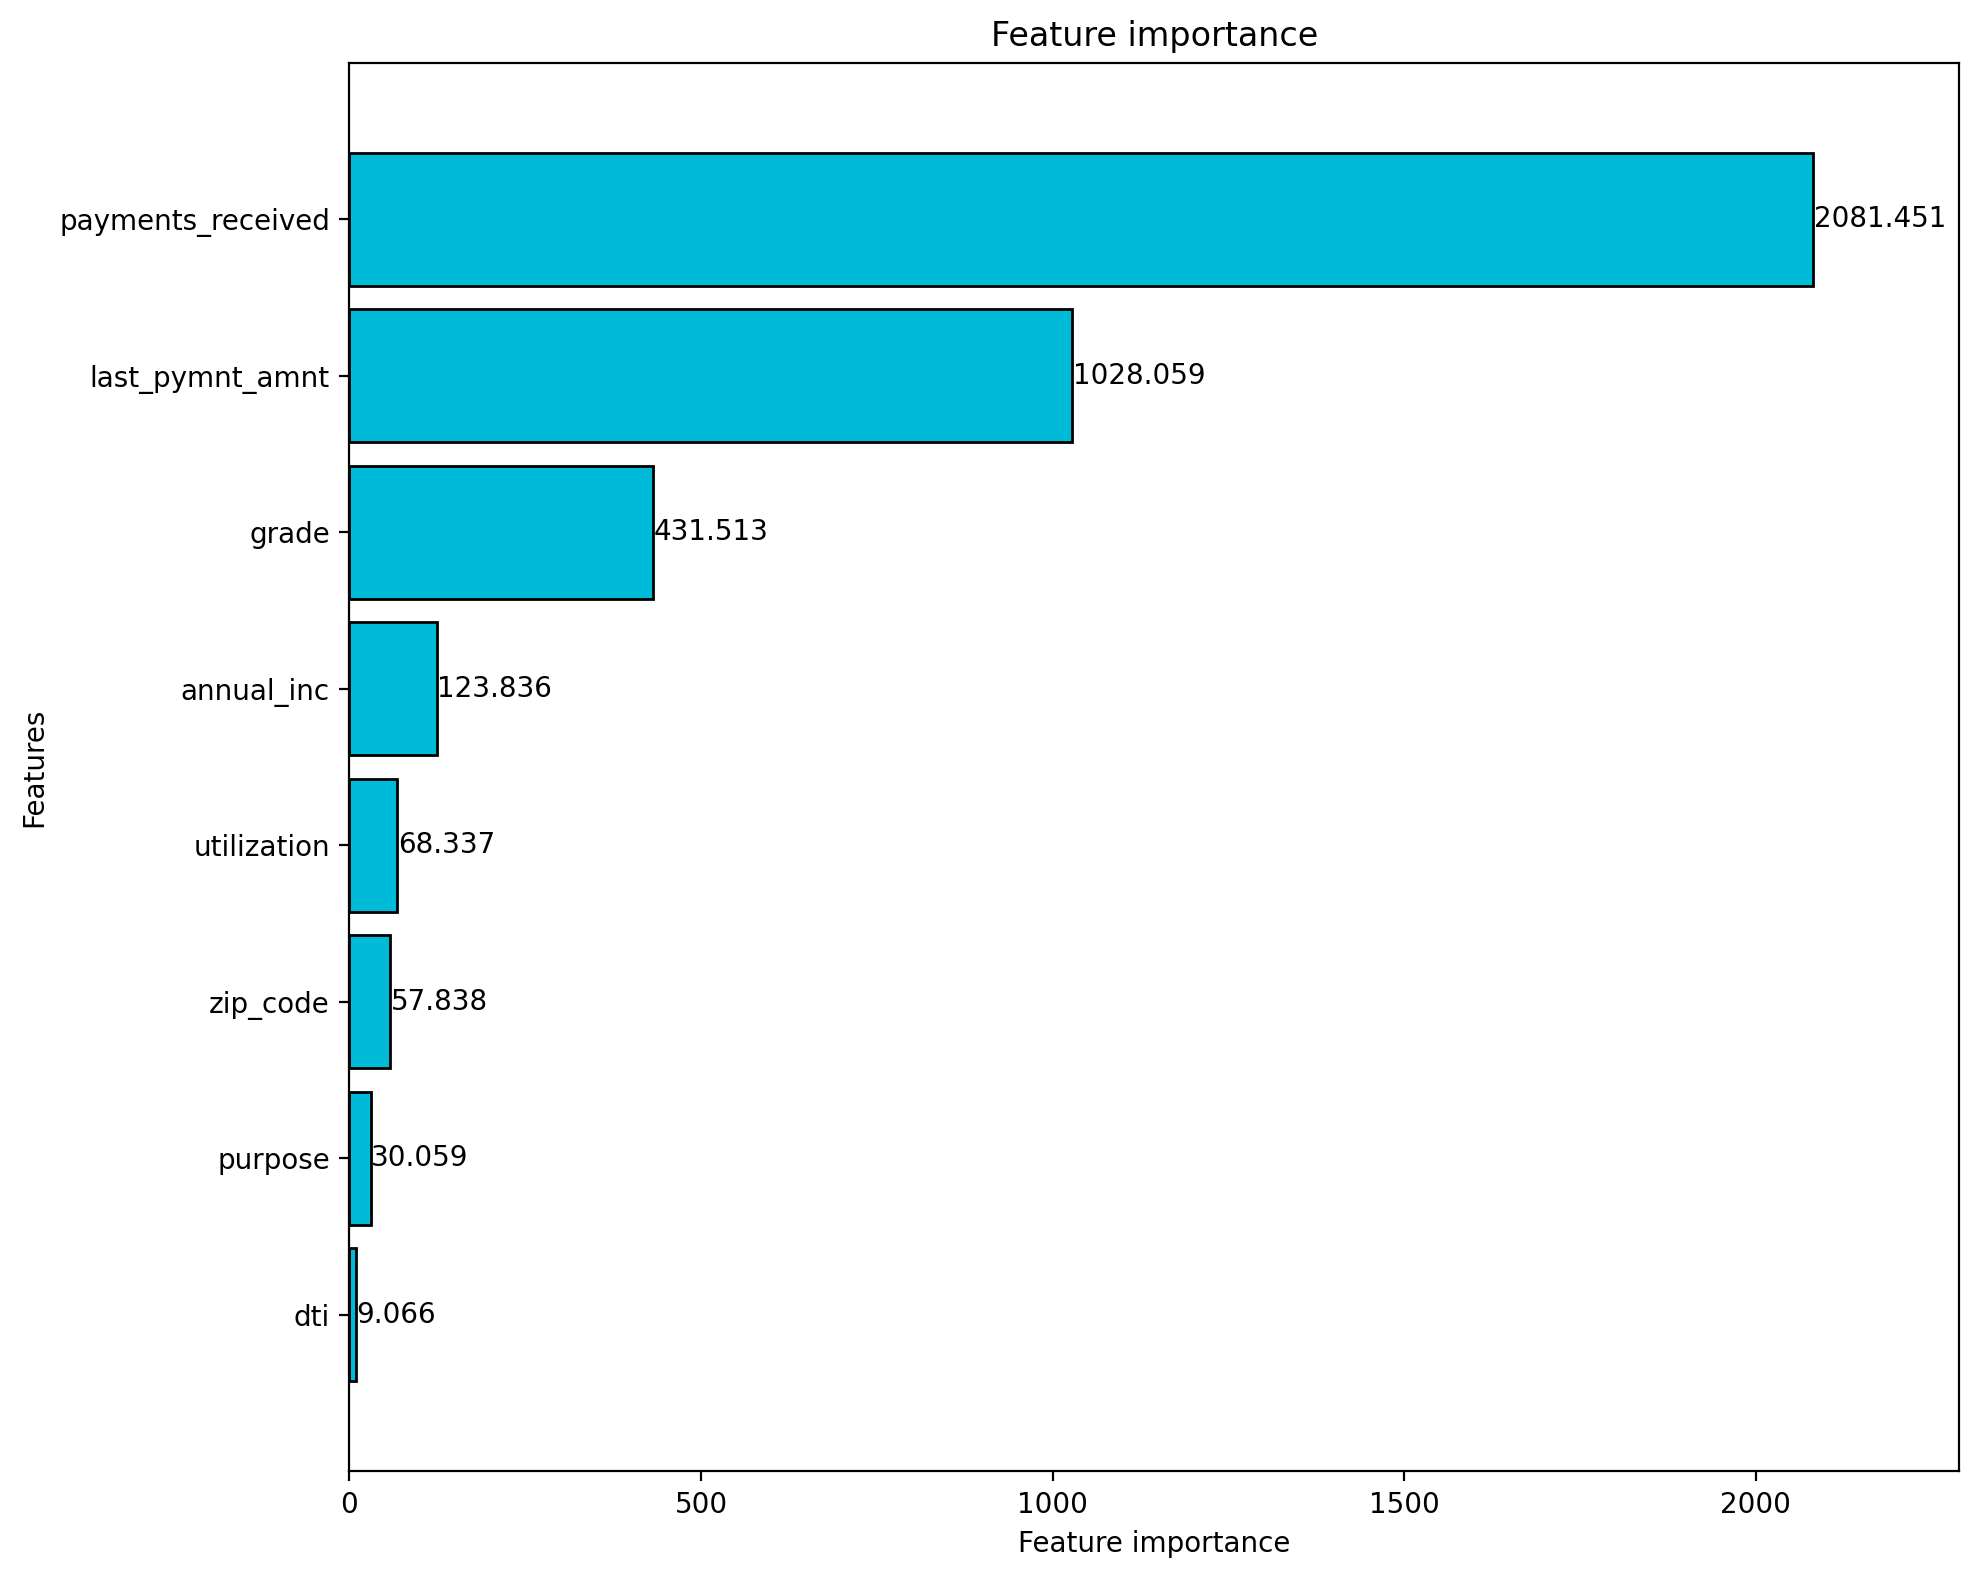

In [39]:
lgb.plot_importance(classifier, 
                    importance_type='gain', 
                    height=0.85, 
                    color='#00BBD7',
                    edgecolor='black', 
                    grid=False,
                    figsize=(10,8))
plt.tight_layout()
plt.show()

## 3 Testing

- Common: rank correlation coefficients such as Somers' D, Spearman Rho, and Kendall's Tau,
- But they are lack of intuitive visual representation similar to the Cumulative Accuracy Profile (CAP) and the Gini coefficient for PD models.

### 3.1 Discrimination testing

In [40]:
def clar(y: np.ndarray, X: np.ndarray) -> float:
    """Calculate Cumulative LGD Accuracy Ratio (CLAR).

    CLAR measures the ability of predicted LGD categories to discriminate
    realized LGD values according to Ozdemir and Miu 2009.

    Args:
        y (np.ndarray): Vector of realized LGD values
        X (np.ndarray): Vector of predicted LGD values

    Returns:
        CLAR value for the predicted and realized LGD categories (np.float)
        Share of observations as a numpy array (np.ndarray)
        Cumulative share of correctly assigned LGD values as a numpy array (np.ndarray)

    Raises:
        ValueError: If either 'X' or 'y' contains NA values
        ValueError: If 'X' and 'y' have different lengths

    References:
        Ozdemir, B., Miu, P., 2009. Basel II Implementation. A Guide to
        Developing and Validating a Compliant Internal Risk Rating System.
        McGraw-Hill, USA.
    """

    if any(pd.isna(X)) or any(pd.isna(y)):
        raise ValueError("Both 'X' and 'y' must not contain NA values")
    
    if len(X) != len(y):
        raise ValueError("Both 'X' and 'y' must be of the same length")
    
    nx = len(X)
    classes = sorted(list(set(X).union(set(y))), reverse=True)
    num = [sum(X == cls) for cls in classes]
    cnum = np.cumsum(num)
    index = np.argsort(X)[::-1]
    X = np.array(X)[index]
    y = np.array(y)[index]
    corr = np.zeros(len(classes))
    
    for i in range(len(classes) - 1):
        if cnum[i] > 0:
            corr[i] = np.sum(y[:cnum[i]] >= classes[i])
    
    corr /= nx
    corr[-1] = 1
    obs = cnum / nx
    
    res = obs[0] * corr[0] / 2
    for i in range(1, len(corr)):
        res += (corr[i] - corr[i-1]) * (obs[i] - obs[i-1]) / 2 + (obs[i] - obs[i-1]) * corr[i-1]
    
    return res * 2, obs, corr

The CLAR coefficient, calculated as twice the area under the CLAR curve, ranges from 0 to 1, with 1 representing perfect discriminatory power.

In [41]:
clar_lr = clar(y.loc[ix_test], X.loc[ix_test]['lgd_pred_lr'])[0]
clar_woe = clar(y.loc[ix_test], X.loc[ix_test]['lgd_pred'])[0]
clar_lr_lgb = clar(y.loc[ix_test], X.loc[ix_test]['lgd_pred_lgb'])[0]

print(f"Linear regression CLAR: {clar_lr:.2%}")
print(f"WOE LR CLAR: {clar_woe:.2%}")
print(f"LGBM CLAR: {clar_lr_lgb:.2%}")

Linear regression CLAR: 82.40%
WOE LR CLAR: 84.63%
LGBM CLAR: 92.10%


### 3.2 Visualization of discrimination (CLAR curve)
Cumulative LGD Accuracy Ratio, introduced by [Ozdemir and Miu (2009)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1365842), is the measure of **discrimination strength** for a risk model and is similar to the Gini score. The visual of CLAR is conceptually similar to the Cumulative Accuracy Profile (CAP) in a Gini test.

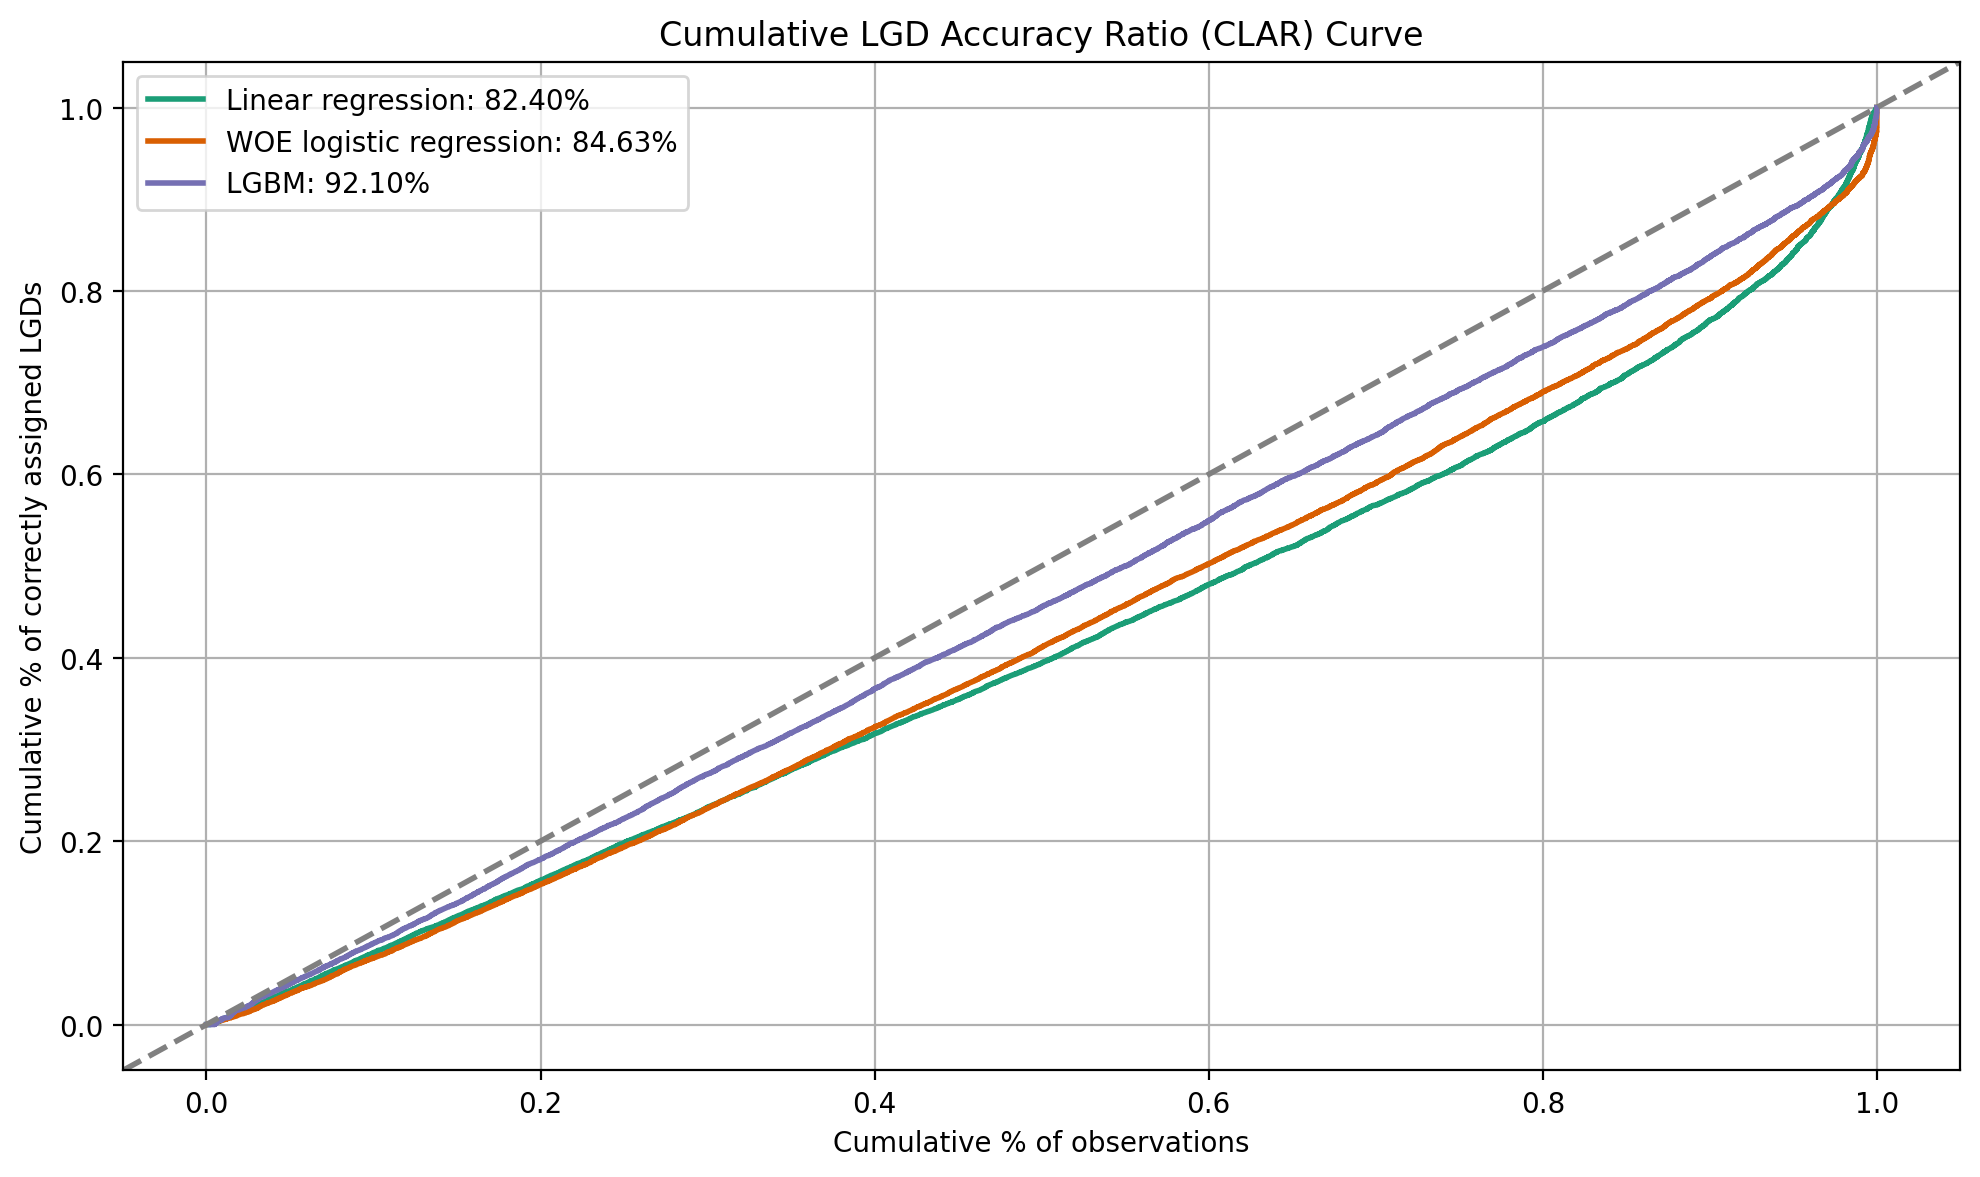

In [42]:
columns = ['lgd_pred_lr', 'lgd_pred', 'lgd_pred_lgb']
labels = ['Linear regression', 'WOE logistic regression', 'LGBM']
data = {}

cmap = plt.get_cmap('Dark2')

# create inputs for the plot
for column in columns:
    clar_value, obs, corr  = clar(y.loc[ix_test].values, X.loc[ix_test, column].values)
    data[column] = {'obs': obs, 'corr': corr, 'clar_value': clar_value}

# create a dataframe
df = pd.DataFrame(data)
num_colors = len(df.columns)

# Plot predictions on a CLAR curve
plt.figure(figsize=(10, 6))

for i, column in enumerate(df.columns):
    color = cmap(i % num_colors)
    plt.plot(df[column]['obs'], 
             df[column]['corr'], 
             color=color,
             linewidth=2,
             label=f"{labels[i]}: {df[column]['clar_value']:.2%}")

# Add a horizontal line representing perfect discrimination
plt.axline((0, 0), slope=1, linestyle='--', linewidth=2, color='gray')

plt.xlabel("Cumulative % of observations")
plt.ylabel("Cumulative % of correctly assigned LGDs")
plt.title("Cumulative LGD Accuracy Ratio (CLAR) Curve")
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('CLAR_curves.png', dpi=600)
plt.show()

> As can be seen from the chart above, LightGBM model produces the most accurate LGD estimates showing the closest proximity to the ideal 45-degree line. However, it's worth mentioning that while it's built using monotonicity constraints to preserve causal knowledge with the target variables, this tree-based model will still be less interpretable compared to linear and logistic regressions which may be an important factor during the regulatory approval.